In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import vlc

In [2]:
#assumes that array is not zero
def scaled(array):
    return (array-np.min(array))/(np.max(array)-np.min(array)) 

In [26]:
def trainEncoderGenerator(case_nums, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE):
    from DataPreprocessor import DataLoader
    dl = DataLoader()
    while True:
        spectral_frames = tf.zeros((BATCH_SIZE, TIMESTEPS, 1025))
        batch_num = 0
        for case_num in case_nums:
            X_array = scaled(dl.make_spectrogram(case_num))
            silence = np.argwhere(np.all(X_array[..., :] == 0, axis=0))
            X_array = np.swapaxes(np.delete(X_array, silence, axis=1), 0, 1)
            L = X_array.shape[0]
            batch_start = 0
            batch_end = TIMESTEPS                        
            while batch_start < L-TIMESTEPS:
                limit = min(batch_end, L)
                X = X_array[batch_start:limit, :]                
                spectral_frames[batch_num, :, :].assign(X)
                batch_num+=1
                if batch_num >= BATCH_SIZE:
                    yield(spectral_frames, spectral_frames)
                    spectral_frames = tf.zeros((BATCH_SIZE, TIMESTEPS, 1025))
                    batch_num = 0
                    tf.print('used batch')              
                batch_start += WINDOWS_STEP #window sliding by half of a window size
                batch_end += WINDOWS_STEP            
            if case_num == case_nums[-1]:
                break

In [13]:
TIMESTEPS = 128
WINDOWS_STEP = 64
N_FEATURES = 1025

In [14]:
input = tf.keras.layers.Input(shape=(TIMESTEPS, N_FEATURES))

encoded = tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)(input)
encoded = tf.keras.layers.LSTM(64, activation='tanh')(encoded)
encoded = tf.keras.layers.Dense(128)(encoded)
encoded = tf.keras.layers.ELU(alpha=0.5)(encoded)
encoded = tf.keras.layers.BatchNormalization(name='embedding')(encoded)

decoded = tf.keras.layers.Dense(256)(encoded)
decoded = tf.keras.layers.ELU(alpha=0.5)(decoded)
decoded = tf.keras.layers.Dense(1024)(decoded)
decoded = tf.keras.layers.ELU(alpha=0.5)(decoded)
decoded = tf.keras.layers.Dense(TIMESTEPS*N_FEATURES, activation='sigmoid')(decoded)
decoded = tf.keras.layers.Reshape([TIMESTEPS, N_FEATURES])(decoded)

autoencoder = tf.keras.models.Model(inputs=input, outputs=decoded)

In [15]:
autoencoder.compile(optimizer='adam', loss='mse')

In [27]:
count = 0
for x in trainEncoderGenerator(VALIDATION_IDX, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE):
    print(x[0].shape)
    count+=1
    if count>4:
        break

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'assign'

In [8]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [16]:
BATCH_SIZE = 32
EPOCHS = 5
TRAIN_IDX = np.arange(0, 225752, 1)
VALIDATION_IDX = np.arange(225752, 322504, 1)
with tf.device("GPU:0"):
    autoencoder.fit(
        trainEncoderGenerator(TRAIN_IDX, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE), 
        epochs=EPOCHS, 
        steps_per_epoch = len(TRAIN_IDX) // BATCH_SIZE,
        verbose = 1,
        validation_data = trainEncoderGenerator(VALIDATION_IDX, TIMESTEPS, WINDOWS_STEP, BATCH_SIZE),
        validation_steps = len(VALIDATION_IDX) // BATCH_SIZE
        )

Epoch 1/5
used batch
   2/7054 [..............................] - ETA: 35:37 - loss: 0.1059WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0220s vs `on_train_batch_end` time: 0.0350s). Check your callbacks.
used batch
  14/7054 [..............................] - ETA: 2:01:40 - loss: 0.0736used batch


KeyboardInterrupt: 

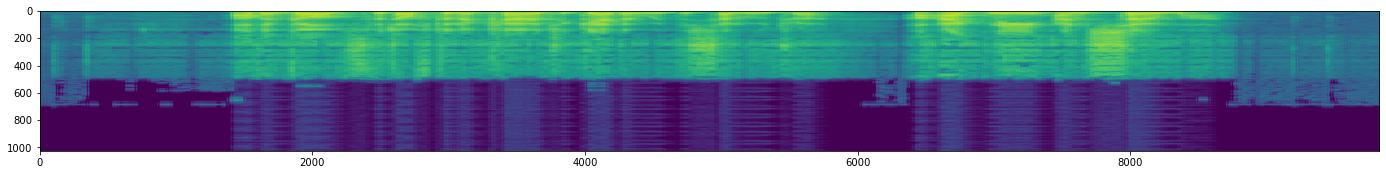

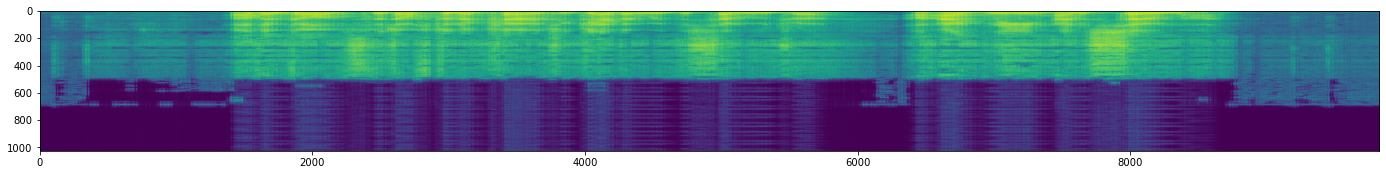

In [23]:
yhat = autoencoder.predict(input_sequence, verbose=0)
fig, ax = plt.subplots(figsize=(24, 5))
ax.imshow(np.swapaxes(np.vstack(input_sequence), 0, 1))
fig, ax = plt.subplots(figsize=(24, 5))
ax.imshow(np.swapaxes(np.vstack(yhat), 0, 1))